# Generate Raw Data
The data will be used as input for feature generation.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

def generate_entities():
    return np.random.randint(0, 10, size=100).astype(np.int32)

def generate_raw_data(entities):
    df = pd.DataFrame(columns=["driver_id", "ts", "amount", "distance"])
    df['driver_id'] = entities
    df['amount'] = np.random.random(size=100).astype(np.float32) * 500
    df['distance'] = np.random.randint(0, 100, size=100).astype(np.int32)
    df['ts'] = pd.to_datetime(
            np.random.randint(
                datetime(2021, 1, 1).timestamp(),
                datetime(2021, 1, 14).timestamp(),
                size=100),
        unit="s"
    )
    return df

entities = generate_entities()
raw_data = generate_raw_data(entities)
raw_data.to_csv('/home/tzhu/data/test_raw_data.csv', index=False)

# Create Client

In [2]:
import os
from feast import Client, Feature, Entity, ValueType, FeatureTable
from feast.feature import SQLFeature
from feast.data_source import FileSource, KafkaSource
from feast.data_format import ParquetFormat, AvroFormat

client = Client()
print(client.version())


{'sdk': {'version': '0.9.0rc2.dev35+g156bd215.d20210217'}, 'serving': 'not configured', 'core': {'url': 'localhost:6565', 'version': '0.10.0-SNAPSHOT'}}


# Inspect Raw Data

In [3]:
client.sample('/home/tzhu/data/test_raw_data.csv', 10)

/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,driver_id,ts,amount,distance
0,1,2021-01-12 08:10:47,8.414104,75
1,7,2021-01-02 10:46:34,106.471610,61
2,8,2021-01-13 03:27:00,25.127504,34
3,5,2021-01-10 17:19:10,491.476300,40
4,8,2021-01-08 04:09:35,377.336000,9
5,4,2021-01-12 04:19:50,374.482970,28
6,0,2021-01-08 19:23:41,491.464080,36
7,1,2021-01-05 23:05:15,15.492278,94
8,3,2021-01-09 03:05:04,72.282690,15
9,6,2021-01-06 02:56:25,333.134800,57


# Define Features and FeatureTables

In [4]:
feature1 = SQLFeature(name='last_7_day_total_trips', query="select driver_id, count(*) over (partition by driver_id order by ts range between interval '7' day preceding and current row) from driver_stats")
feature2 = SQLFeature(name='last_7_day_avg_amount', query="select driver_id, avg(amount) over (partition by driver_id order by ts range between interval '7' day preceding and current row) from driver_stats")
feature3 = SQLFeature(name='last_7_day_amounts', query="select driver_id, avg(amount) over (partition by driver_id order by ts range between interval '7' day preceding and current row), sum(amount) over (partition by driver_id order by ts range between interval '7' day preceding and current row) from driver_stats")

driver_id = Entity(name="driver_id", description="Driver identifier", value_type=ValueType.INT64)
# client.apply(driver_id)

feature_table = FeatureTable(
    name = "driver_stats",
    entities = ["driver_id"],
    features = [
        feature1,
        feature3,
    ],
    batch_source=FileSource(
        event_timestamp_column="ts",
        file_format=ParquetFormat(),
        file_url='/home/tzhu/data/test_data',
    )
)


# client.apply_feature_table(feature_table)

/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Discover Existing Feature Tables

In [5]:
print(client.list_feature_tables())
print(client.list_entities())

[FeatureTable <driver_stats>]


# Get Offline/Batch Features

In [6]:

raw_data = client.sample('/home/tzhu/data/test_raw_data.csv', 100)
offline_features = client.get_offline(feature_table, raw_data)
offline_features[:15]

,driver_id,ts,amount,distance,last_7_day_total_trips,last_7_day_amounts
21,5,2020-12-31 20:18:01,204.43950,8,"(1,)","(204.4395000000000000, 204.4395)"
91,3,2020-12-31 21:14:08,130.78714,44,"(1,)","(130.7871400000000000, 130.78714)"
95,8,2021-01-01 03:12:09,125.52532,92,"(1,)","(125.5253200000000000, 125.52532)"
32,6,2021-01-01 08:35:25,366.06665,60,"(1,)","(366.0666500000000000, 366.06665)"
29,7,2021-01-01 10:27:52,71.95679,71,"(1,)","(71.9567900000000000, 71.95679)"
93,1,2021-01-01 11:28:32,202.08807,20,"(1,)","(202.0880700000000000, 202.08807)"
20,7,2021-01-01 12:36:50,269.54663,22,"(2,)","(170.7517100000000000, 341.50342)"
33,3,2021-01-01 18:30:27,485.09964,0,"(2,)","(307.9433900000000000, 615.88678)"
25,1,2021-01-02 04:22:24,496.23734,62,"(2,)","(349.1627050000000000, 698.32541)"
79,7,2021-01-02 06:31:06,127.77805,94,"(3,)","(156.4271566666666667, 469.28147)"


# Get Online/Realtime Features


In [7]:
client.offline_to_online(feature_table, offline_features)
entities = {'driver_id': [0, 2]}
resp = client.get_online(feature_table, entities)
resp

select * from driver_stats_features where driver_id in (0, 2) order by ts desc;
/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,driver_id,amount,distance,ts,last_7_day_total_trips,last_7_day_amounts
0,0,12.15545,53,2021-01-12 18:39:10,[8],"[199.2314833749999950, 1593.85186699999996]"
1,2,29.417915,96,2021-01-09 02:48:41,[6],"[233.7382063333333300, 1402.42923799999998]"


# Feature Transformation

In [8]:
def transform(data: pd.DataFrame) -> pd.DataFrame:
    features = data.copy(deep=True)
    features.pop('ts')
    features.pop('driver_id')
    features['f0'] = offline_features['last_7_day_total_trips'].str[0]
    features['f1'] = offline_features['last_7_day_amounts'].str[0]
    features['f2'] = offline_features['last_7_day_amounts'].str[1]
    features.pop('last_7_day_total_trips')
    features.pop('last_7_day_amounts')
    return features

features = transform(offline_features)

/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train and Score a Model Offline

## Random Labels

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0.5333333333333333
0.525


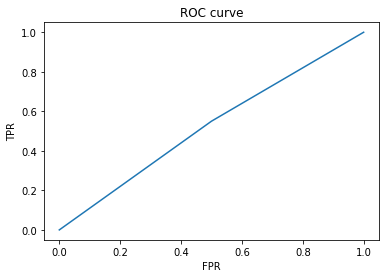

In [10]:
random_labels = np.random.randint(0, 2, size=100).astype(np.int32)

X_train = features[:70]
y_train = random_labels[:70]
X_test = features[70:]
y_test = random_labels[70:]

clf1 = DecisionTreeClassifier(random_state=0)
clf1.fit(X_train, y_train)
print(clf1.score(X_test, y_test))

predictions = clf1.predict(X_test)
print(roc_auc_score(y_test, predictions))
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Meaningful Labels

/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0.9210526315789473


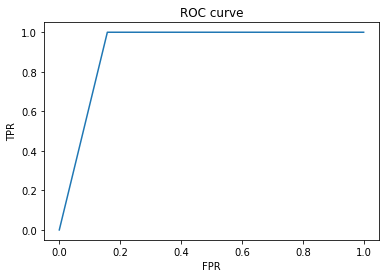

In [11]:
labels = []
for item in features.itertuples():
    amount = item[1]
    distance = item[2]
    avg_amount = item[4]
    if amount > avg_amount and distance > 20:
        labels.append(1)
    else:
        labels.append(0)

X_train = features[:70]
y_train = labels[:70]
X_test = features[70:]
y_test = labels[70:]

clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test)

predictions = clf2.predict(X_test)
print(roc_auc_score(y_test, predictions))
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

# Online Prediction

In [12]:
entities = {'driver_id': [0, 2]}
resp = client.get_online(feature_table, entities)
print(clf1.predict(transform(resp)))
print(clf2.predict(transform(resp)))

select * from driver_stats_features where driver_id in (0, 2) order by ts desc;
[1 1]
[0 0]
/home/tzhu/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
